In [1]:
grid_file = '/home/benr/src/ssm-analysis/SSM_Grid/ssm_grid.2dm'

import configparser
import re
import os

from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from fvcom import FvcomGrid, Transect, ControlVolume

In [2]:
data = Dataset('results/phyto.nc')
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    model_start: 2014-01-01 00:00:00
    dimensions(sizes): time(4380), node(3137), nele(4129)
    variables(dimensions): int32 node(node), float32 h(node), float32 x(node), float32 y(node), int32 nele(nele), float32 time(time), float32 controlB1_mean,photic(time, node), float32 controlB2_mean,photic(time, node), float32 c2936B1_mean,photic(time, node), float32 c2936B2_mean,photic(time, node), float32 q1c454B1_mean,photic(time, node), float32 q1c454B2_mean,photic(time, node), float32 q1c10B1_mean,photic(time, node), float32 q1c10B2_mean,photic(time, node), float32 q1c15B1_mean,photic(time, node), float32 q1c15B2_mean,photic(time, node), float32 q1c20B1_mean,photic(time, node), float32 q1c20B2_mean,photic(time, node), float32 q1c25B1_mean,photic(time, node), float32 q1c25B2_mean,photic(time, node), float32 q1c2936B1_mean,photic(time, node), float32 q1c2936B2_mean,photic(time, node), float32 q3c454B1_me

In [3]:
def sort(vs):
    r = re.compile('q([1-9])c([0-9]+)')
    dec = []
    for v in vs:
        if v[-14:] != 'B1_mean,photic':
            continue
        n = v[:-14] # Remove 'B1_mean,photic'
        m = r.match(n)
        if m:
            q = m.group(1)
            c = m.group(2)
            if c == '454':
                c = '0' + c
        else:
            if n == 'control':
                q = '0'
                c = '0'
            else:
                q = '0'
                c = '1'
        dec.append((q, c, n))
    dec.sort()
    return [n for q, c, n in dec]

sort(data.variables)

['control',
 'c2936',
 'q1c454',
 'q1c10',
 'q1c15',
 'q1c20',
 'q1c25',
 'q1c2936',
 'q3c454',
 'q3c10',
 'q3c15',
 'q3c20',
 'q3c25',
 'q3c2936',
 'q5c454',
 'q5c10',
 'q5c15',
 'q5c20',
 'q5c25',
 'q5c2936',
 'q7c454',
 'q7c10',
 'q7c15',
 'q7c20',
 'q7c25',
 'q7c2936',
 'q9c454',
 'q9c10',
 'q9c15',
 'q9c20',
 'q9c25',
 'q9c2936']

In [4]:
grid = FvcomGrid.from_mesh(grid_file)
areas = grid.tces_gdf().loc[data['node'][:]].area
areas

4478     1.290208e+06
4479     1.012244e+06
4480     1.511056e+06
4481     1.856297e+06
4482     1.190541e+06
             ...     
15989    2.452663e+05
15993    2.198963e+05
15994    1.809223e+05
16000    9.728483e+04
16003    2.510567e+05
Length: 3137, dtype: float64

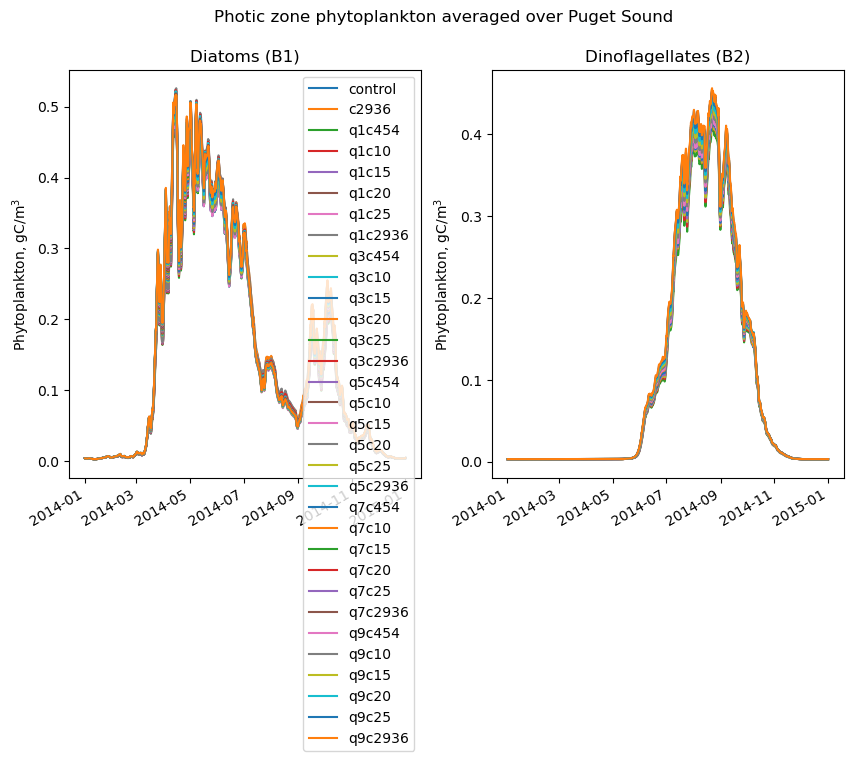

In [5]:
dates = pd.Timestamp(data.model_start) + pd.to_timedelta(data['time'][:], 'D')
fig, axs = plt.subplots(1, 2, figsize=(10,6))
phyto_avgs = {}
for name in sort(data.variables):
    ser1 = pd.Series(np.average(data[name + 'B1_mean,photic'][:], axis=1, weights=areas), index=dates)
    ser1.rolling('1D').mean().plot(ax=axs[0], label=name)
    phyto_avgs[name + '_diatom'] = ser1
    ser2 = pd.Series(np.average(data[name + 'B2_mean,photic'][:], axis=1, weights=areas), index=dates)
    ser2.rolling('1D').mean().plot(ax=axs[1], label=name)
    phyto_avgs[name + '_dinofl'] = ser2
phyto_avgs_df = pd.DataFrame(phyto_avgs)
fig.suptitle('Photic zone phytoplankton averaged over Puget Sound')
axs[0].set(title='Diatoms (B1)', ylabel='Phytoplankton, gC/m$^3$')
axs[1].set(title='Dinoflagellates (B2)', ylabel='Phytoplankton, gC/m$^3$')
axs[0].legend()

In [6]:
phyto_avgs_df.to_excel('results/puget_sound/phyto_avg_gcm-3.xlsx')

In [7]:
sections_file = 'inlet_sections_aurora.ini'
sections_config = configparser.ConfigParser()
sections_config.read(sections_file)

# names of sections that bound each control volume
cv_bounds = {
    'Penn Cove': ['PennCove'],
    'Holmes Harbor': ['HolmesHbr'],
    'Crescent Bay': ['CrescentBy'],
    'Carr Inlet': ['CarrInl'],
    'Case Inlet': ['CaseInl'],
    'Elliot Bay': ['ElliotBy'],
    'Commencement Bay': ['CommenceBy'],
    'Dabob Bay': ['DabobBy'],
    'Port Susan': ['PtSusan','StillaguamishSouthFork','StillaguamishPassSouth'],
    'Dyes Inlet': ['DyesInl'],
    'Sinclair Inlet': ['SinclairInl'],
    'Quartermaster Harbor': ['QtrHbr'],
    'Lynch Cove': ['LynchCove']
}

In [8]:
dirname = lambda n: n.lower().replace(' ', '_')

cvs = {}
for name, sectnames in cv_bounds.items():
    transects = []
    display(name)
    for sn in sectnames:
        waypoints = np.array(sections_config[sn]['waypoints'].split(' ')).astype(int)
        t = Transect.shortest(grid, waypoints)
        transects.append(t)
    cvs[name] = ControlVolume.from_transects(transects, calc=True)
    if not os.path.isdir(f'results/{dirname(name)}'):
        os.mkdir(f'results/{dirname(name)}')
    display(len(cvs[name].nodes))

'Penn Cove'

14

'Holmes Harbor'

26

'Crescent Bay'

10

'Carr Inlet'

157

'Case Inlet'

100

'Elliot Bay'

166

'Commencement Bay'

60

'Dabob Bay'

104

'Port Susan'

190

'Dyes Inlet'

42

'Sinclair Inlet'

16

'Quartermaster Harbor'

40

'Lynch Cove'

96

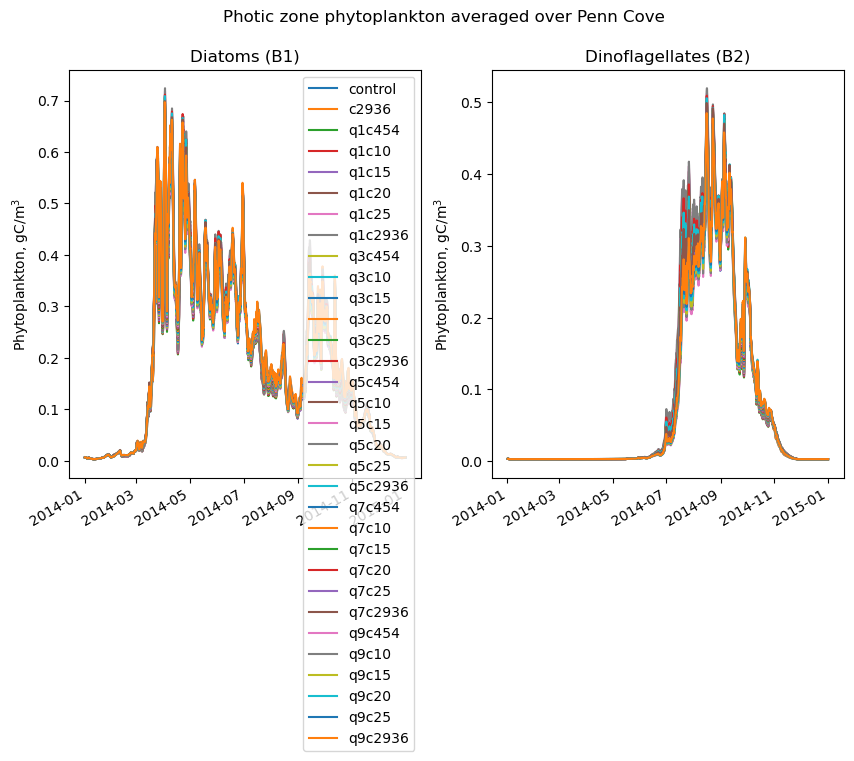

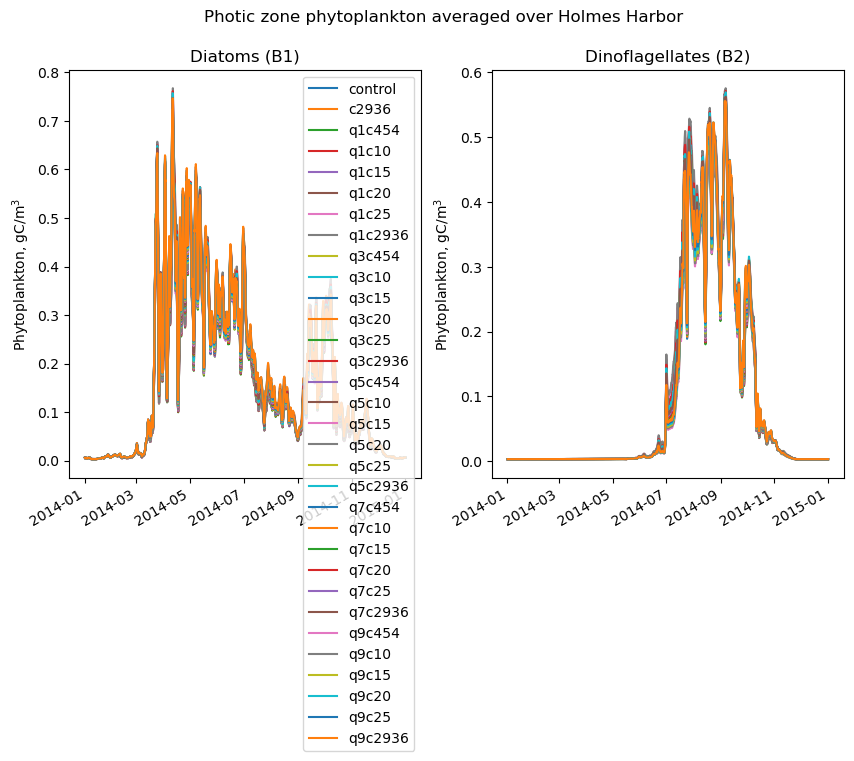

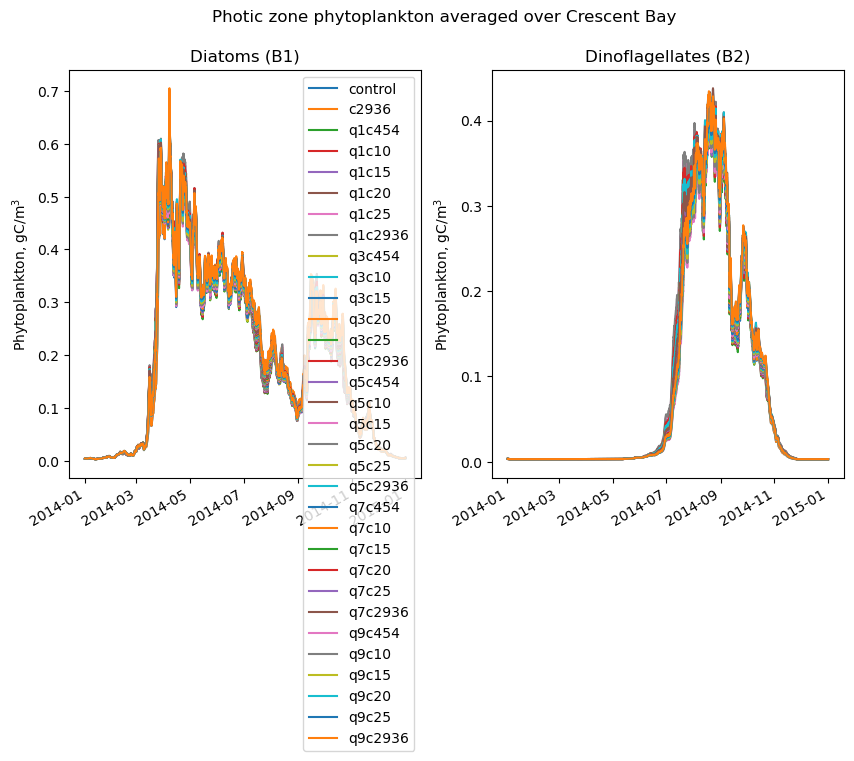

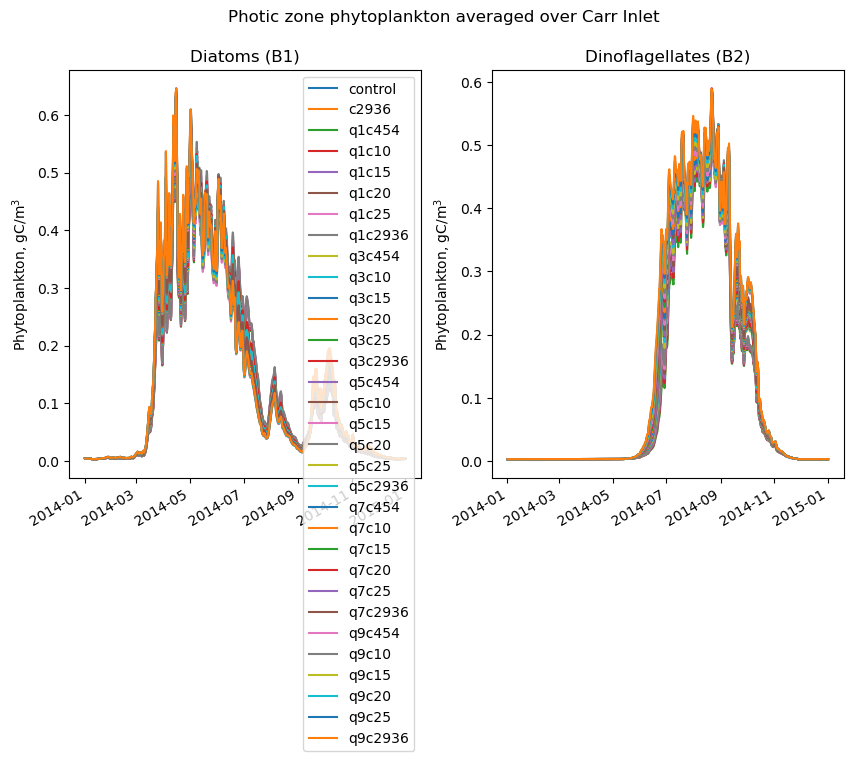

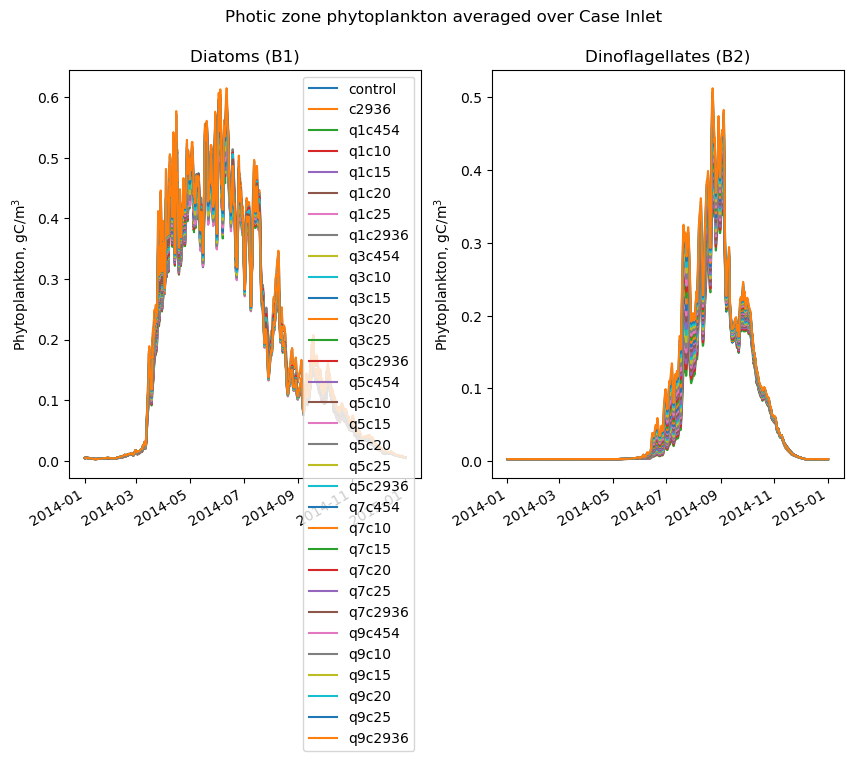

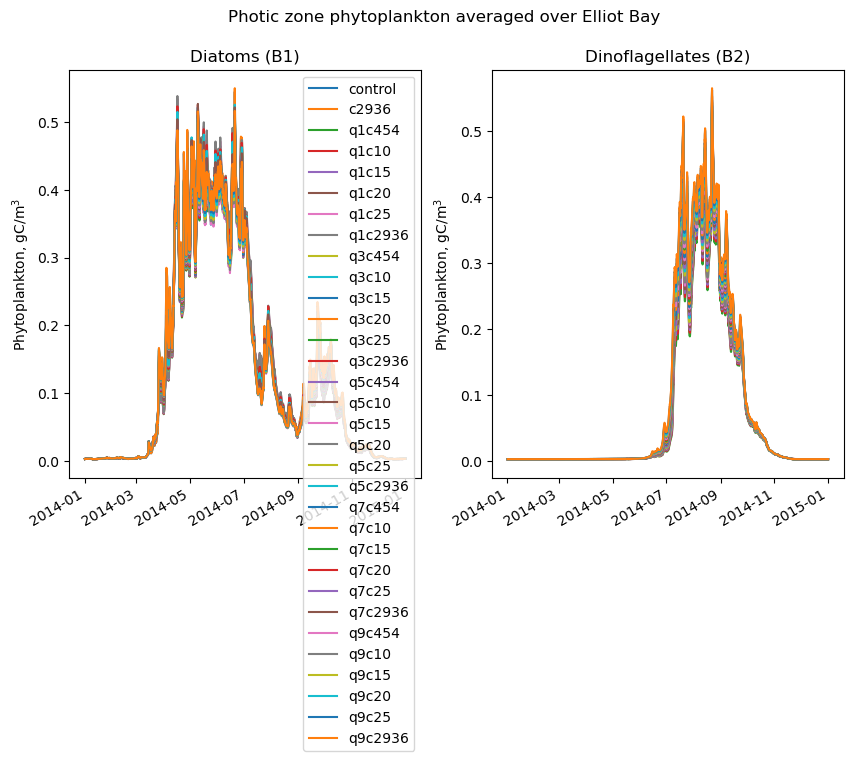

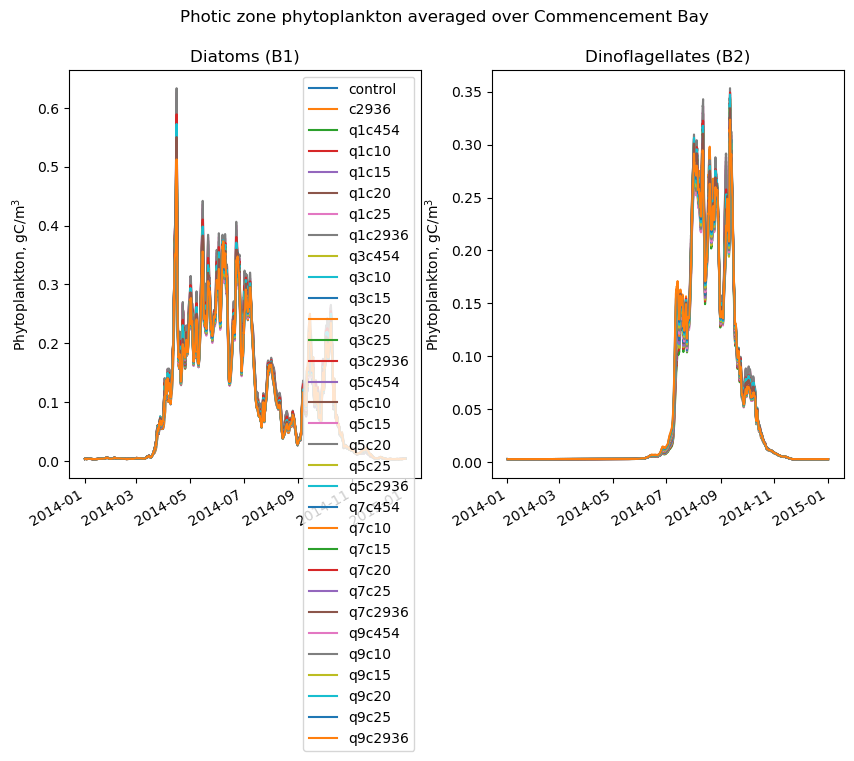

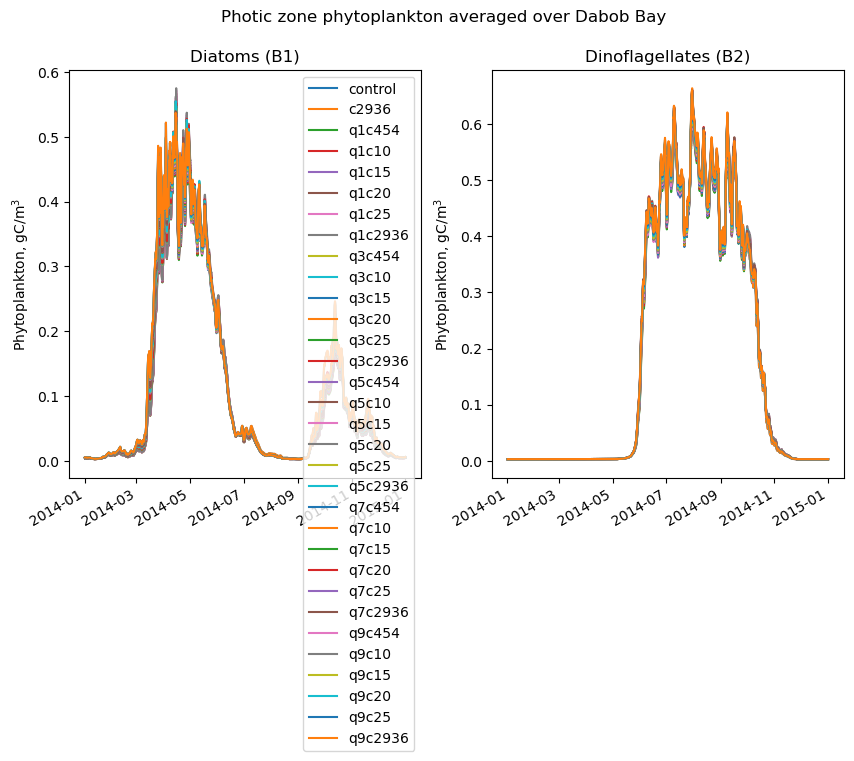

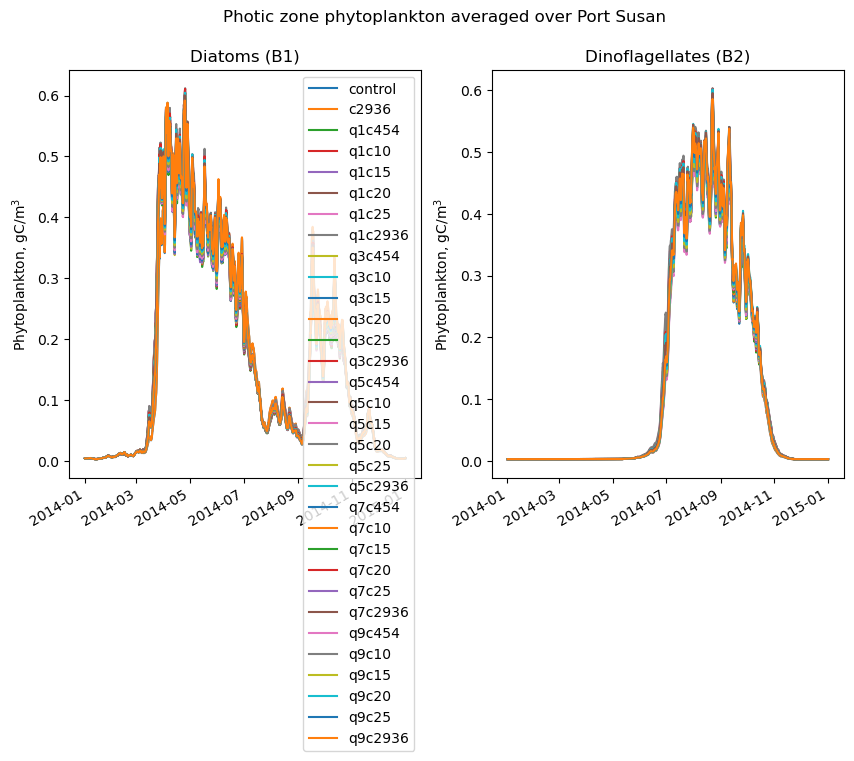

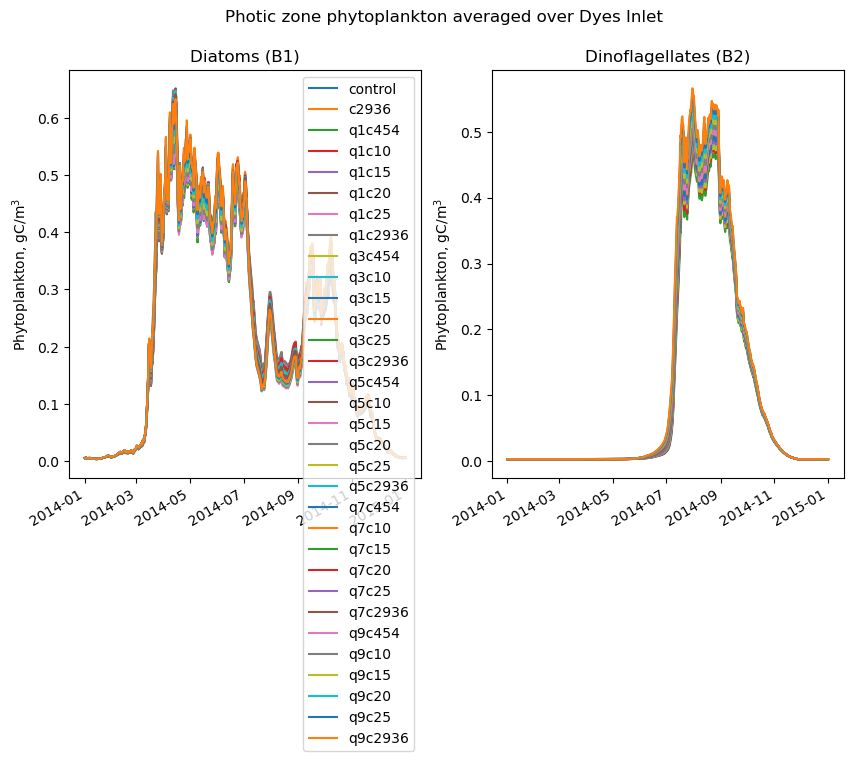

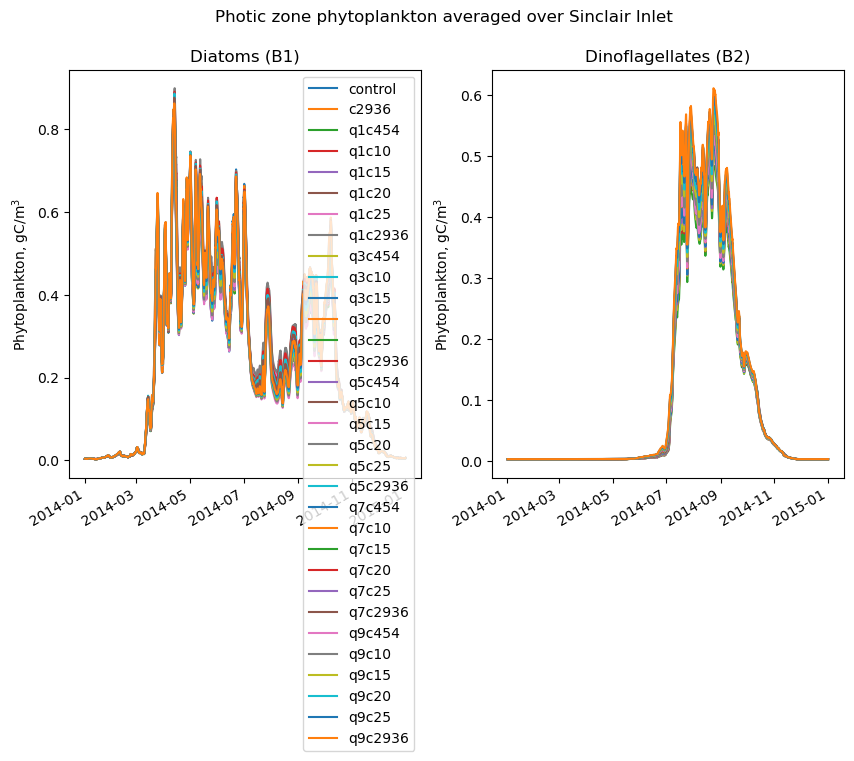

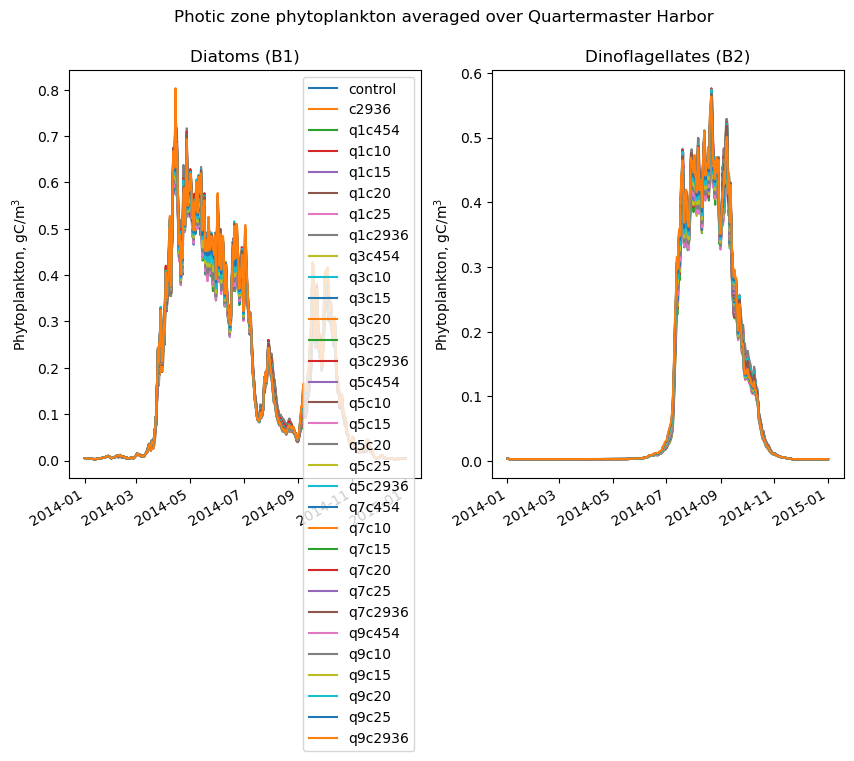

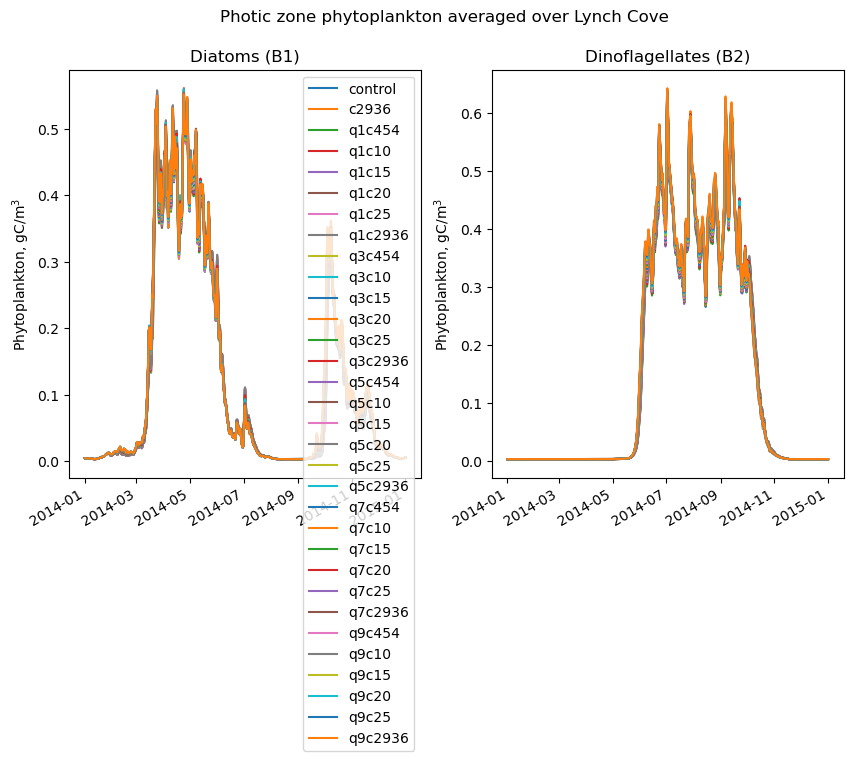

In [9]:
phyto_avgs_by_cv = {}
for cvname,cv in cvs.items():
    fig, axs = plt.subplots(1, 2, figsize=(10,6))
    phyto_avgs = {}
    idxs = np.searchsorted(data['node'][:], np.array(list(cv.nodes & set(data['node'][:]))))
    for name in sort(data.variables):
        ser1 = pd.Series(np.average(data[name + 'B1_mean,photic'][:,idxs], axis=1, weights=areas.iloc[idxs]), index=dates)
        ser1.rolling('1D').mean().plot(ax=axs[0], label=name)
        phyto_avgs[name + '_diatom'] = ser1
        ser2 = pd.Series(np.average(data[name + 'B2_mean,photic'][:,idxs], axis=1, weights=areas.iloc[idxs]), index=dates)
        ser2.rolling('1D').mean().plot(ax=axs[1], label=name)
        phyto_avgs[name + '_dinofl'] = ser2
    phyto_avgs_by_cv[cvname] = pd.DataFrame(phyto_avgs)
    fig.suptitle(f'Photic zone phytoplankton averaged over {cvname}')
    axs[0].set(title='Diatoms (B1)', ylabel='Phytoplankton, gC/m$^3$')
    axs[1].set(title='Dinoflagellates (B2)', ylabel='Phytoplankton, gC/m$^3$')
    axs[0].legend()

In [10]:
for name,df in phyto_avgs_by_cv.items():
    display(name)
    display(df.mean())
    df.to_excel(f'results/{dirname(name)}/phyto_avg_gcm-3.xlsx')

'Penn Cove'

control_diatom    0.195239
control_dinofl    0.075186
c2936_diatom      0.196693
c2936_dinofl      0.076064
q1c454_diatom     0.182995
                    ...   
q9c20_dinofl      0.075605
q9c25_diatom      0.192679
q9c25_dinofl      0.076898
q9c2936_diatom    0.194490
q9c2936_dinofl    0.078027
Length: 64, dtype: float64

'Holmes Harbor'

control_diatom    0.171200
control_dinofl    0.089612
c2936_diatom      0.172490
c2936_dinofl      0.090660
q1c454_diatom     0.154049
                    ...   
q9c20_dinofl      0.090727
q9c25_diatom      0.169456
q9c25_dinofl      0.092202
q9c2936_diatom    0.171026
q9c2936_dinofl    0.093544
Length: 64, dtype: float64

'Crescent Bay'

control_diatom    0.197318
control_dinofl    0.076007
c2936_diatom      0.198894
c2936_dinofl      0.076961
q1c454_diatom     0.185252
                    ...   
q9c20_dinofl      0.078862
q9c25_diatom      0.197621
q9c25_dinofl      0.080112
q9c2936_diatom    0.199424
q9c2936_dinofl    0.081212
Length: 64, dtype: float64

'Carr Inlet'

control_diatom    0.146896
control_dinofl    0.129051
c2936_diatom      0.148372
c2936_dinofl      0.131022
q1c454_diatom     0.132288
                    ...   
q9c20_dinofl      0.132942
q9c25_diatom      0.139575
q9c25_dinofl      0.135082
q9c2936_diatom    0.140872
q9c2936_dinofl    0.136930
Length: 64, dtype: float64

'Case Inlet'

control_diatom    0.203009
control_dinofl    0.069444
c2936_diatom      0.205641
c2936_dinofl      0.071566
q1c454_diatom     0.174834
                    ...   
q9c20_dinofl      0.080676
q9c25_diatom      0.191907
q9c25_dinofl      0.082002
q9c2936_diatom    0.193840
q9c2936_dinofl    0.083140
Length: 64, dtype: float64

'Elliot Bay'

control_diatom    0.142331
control_dinofl    0.081968
c2936_diatom      0.143277
c2936_dinofl      0.082937
q1c454_diatom     0.129923
                    ...   
q9c20_dinofl      0.082898
q9c25_diatom      0.135307
q9c25_dinofl      0.084146
q9c2936_diatom    0.136332
q9c2936_dinofl    0.085220
Length: 64, dtype: float64

'Commencement Bay'

control_diatom    0.097807
control_dinofl    0.049672
c2936_diatom      0.098488
c2936_dinofl      0.050146
q1c454_diatom     0.104941
                    ...   
q9c20_dinofl      0.047624
q9c25_diatom      0.099348
q9c25_dinofl      0.048288
q9c2936_diatom    0.100142
q9c2936_dinofl    0.048868
Length: 64, dtype: float64

'Dabob Bay'

control_diatom    0.115450
control_dinofl    0.181843
c2936_diatom      0.115806
c2936_dinofl      0.182516
q1c454_diatom     0.102482
                    ...   
q9c20_dinofl      0.181871
q9c25_diatom      0.114444
q9c25_dinofl      0.183062
q9c2936_diatom    0.114964
q9c2936_dinofl    0.184130
Length: 64, dtype: float64

'Port Susan'

control_diatom    0.167827
control_dinofl    0.118676
c2936_diatom      0.169072
c2936_dinofl      0.120185
q1c454_diatom     0.160778
                    ...   
q9c20_dinofl      0.120662
q9c25_diatom      0.166923
q9c25_dinofl      0.122609
q9c2936_diatom    0.168492
q9c2936_dinofl    0.124304
Length: 64, dtype: float64

'Dyes Inlet'

control_diatom    0.232361
control_dinofl    0.106820
c2936_diatom      0.234525
c2936_dinofl      0.107429
q1c454_diatom     0.213136
                    ...   
q9c20_dinofl      0.109726
q9c25_diatom      0.225964
q9c25_dinofl      0.111646
q9c2936_diatom    0.228570
q9c2936_dinofl    0.113272
Length: 64, dtype: float64

'Sinclair Inlet'

control_diatom    0.247938
control_dinofl    0.106991
c2936_diatom      0.249601
c2936_dinofl      0.106762
q1c454_diatom     0.228319
                    ...   
q9c20_dinofl      0.107147
q9c25_diatom      0.240526
q9c25_dinofl      0.109863
q9c2936_diatom    0.244450
q9c2936_dinofl    0.112195
Length: 64, dtype: float64

'Quartermaster Harbor'

control_diatom    0.190244
control_dinofl    0.095573
c2936_diatom      0.192325
c2936_dinofl      0.096532
q1c454_diatom     0.177435
                    ...   
q9c20_dinofl      0.094471
q9c25_diatom      0.191948
q9c25_dinofl      0.096355
q9c2936_diatom    0.194544
q9c2936_dinofl    0.098094
Length: 64, dtype: float64

'Lynch Cove'

control_diatom    0.119394
control_dinofl    0.154582
c2936_diatom      0.119731
c2936_dinofl      0.155044
q1c454_diatom     0.115621
                    ...   
q9c20_dinofl      0.153376
q9c25_diatom      0.121969
q9c25_dinofl      0.154473
q9c2936_diatom    0.122546
q9c2936_dinofl    0.155416
Length: 64, dtype: float64